<a href="https://colab.research.google.com/github/raghu-sanikommu/mm-rag/blob/main/mmRAG_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG 🔍

Dev Info:
- Embedding Dimension of gemini model: 768

## Phase 1:

- Upload PDF
- Extract text & images from PDF using `unstructured`
- Split the text chunks based on token limit
- Generate text embeddings for texts splitted
- Generate image summary within token limit using LLM by passing image to Vision LLM `gemini`
- Generate text embeddings for summary generated

In [ ]:
!apt-get -qq install poppler-utils tesseract-ocr
%pip install -q --user --upgrade pillow
%pip install -q unstructured["pdf"]

!pip install --quiet -U langchain-text-splitters tiktoken

!pip install --quiet -U google-generativeai

In [ ]:
# Install NLTK Data
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
!mkdir -p pdfs
!mkdir -p images

In [ ]:
from unstructured.partition.pdf import partition_pdf
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
import base64
from google.colab import userdata
import google.generativeai as genai
import PIL.Image

In [ ]:
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

text_embedding_model = "models/text-embedding-004"
text_embedding_model_for_text_splitting = "text-embedding-3-small" # since encoding of models/text-embedding-004 isn't available yet
llm_model = 'gemini-1.5-flash'
images_folder_path = '/content/images'
pdfs_folder_path = '/content/pdfs'
extracted_pdfs = []
texts_to_embed = []
images_to_embed = []

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name=text_embedding_model_for_text_splitting,
    chunk_size=100,
    chunk_overlap=0,
)

genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel(llm_model)

In [ ]:
for pdf_file in sorted(os.listdir(pdfs_folder_path)):
  pdf_path = os.path.join(pdfs_folder_path, pdf_file)
  print("Extracting content from PDF - " + pdf_path)
  try:
    extracted_pdfs.append({
        "chunks": partition_pdf(pdf_path,
            extract_images_in_pdf=True,
            extract_image_block_output_dir=os.path.join(images_folder_path, pdf_file)),
        "filename": pdf_file
      }
    )
  except PIL.UnidentifiedImageError as e:
    print(f"Error processing {pdf_file}: {e}")

In [ ]:
[len(extracted_pdfs[i]['chunks']) for i in range(len(extracted_pdfs))]

In [ ]:
for extracted_pdf in extracted_pdfs:
  total_chunks = len(extracted_pdf.get('chunks'))

  for index, chunk in enumerate(extracted_pdf.get('chunks')):
    print(f'Processing chunk {index+1}/{total_chunks} of {extracted_pdf.get("filename")}');

    if chunk.category != "Image":
      splitted_text = text_splitter.split_text(chunk.text)
      texts_to_embed.extend([{
          "type": "text",
          "filename": extracted_pdf.get('filename'),
          "text": text,
          "embedding": genai.embed_content(model=text_embedding_model, content=text)['embedding']} for text in splitted_text])

In [ ]:
# texts_to_embed
print(len(texts_to_embed))

In [ ]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for folder in sorted(os.listdir(images_folder_path)):
  file_imgs_folder = os.path.join(images_folder_path, folder)

  for img_file in sorted(os.listdir(file_imgs_folder)):
    encoded_image = encode_image(os.path.join(file_imgs_folder, img_file))

    print("Summarizing & embedding image - " + os.path.join(file_imgs_folder, img_file))
    raw_img = PIL.Image.open(os.path.join(file_imgs_folder, img_file))
    gemini_res = gemini_model.generate_content(["Give a brief description of attached image to store it in Vector Database for RAG Search within 100 tokens. Also specify its an image so that RAG can understand its an image description", raw_img])
    images_to_embed.append({
        "type": "image",
        "base64_image": encoded_image,
        "filename": folder,
        "text": gemini_res.text,
        "embedding": genai.embed_content(model=text_embedding_model, content=gemini_res.text)['embedding']
        })


In [ ]:
images_to_embed[0]["text"]
# print(len(images_to_embed))

# Phase 2:

- Create a vector search index in mongoDB
- Store text & embeddings in MongoDB Vector Store

In [ ]:
!pip install pymongo

In [ ]:
from pymongo import MongoClient

client = MongoClient(userdata.get('MONGODB_URI'))
collection = client['mm_rag']['pdfs']

In [ ]:
print(f'Inserting {len(texts_to_embed) + len(images_to_embed)} records')
collection.insert_many(texts_to_embed)
collection.insert_many(images_to_embed)

In [ ]:
len(list(collection.find()))

# Phase 3:

- Take user query
- Generate embedding vector for it
- Query it against Vector Storage and pull top `5` matches

In [27]:
# user_query = input("Enter your query: ")
user_query = "What is Creatine Monohydrate?"

🔴 🔴 🔴 Helpers - Start: 🔴 🔴 🔴

In [ ]:
# collection.delete_many({})

In [ ]:
# !pip install --quiet -U google-generativeai
# !pip install pymongo

# from google.colab import userdata
# import google.generativeai as genai
# from pymongo import MongoClient

# text_embedding_model = "models/text-embedding-004"
# llm_model = 'gemini-1.5-flash'
# GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# genai.configure(api_key=GOOGLE_API_KEY)
# gemini_model = genai.GenerativeModel(llm_model)

# client = MongoClient(userdata.get('MONGODB_URI'))
# collection = client['mm_rag']['pdfs']

🔴 🔴 🔴 Helpers - End 🔴 🔴 🔴

In [28]:
embedded_user_query = genai.embed_content(model=text_embedding_model, content=user_query)['embedding']

print(len(embedded_user_query))

768


In [29]:
relevant_chunks = list(collection.aggregate([
  {
    "$vectorSearch": {
      "index": "idx_mmrag_pdfs",
      "path": "embedding",
      "queryVector": embedded_user_query,
      "numCandidates": 10,
      "limit": 5
    }
  },
  {
    "$project": {
      "_id": 0,
      "filename": 1,
      "type": 1,
      "text": 1,
      "base64_image": 1,
      "score": { "$meta": "vectorSearchScore" }
    }
  }
]))

In [30]:
relevant_chunks

[{'type': 'text',
  'filename': 'gym_supps.pdf',
  'text': 'The most well-known benefit of creatine is its ability to enhance muscle growth and improve physical performance. When taken as a supplement, creatine increases the availability of phosphocreatine in muscles, which helps regenerate ATP, the primary energy carrier in cells. This process allows for greater energy production during high- intensity exercise, leading to improved strength, endurance, and muscle mass. Numerous studies have confirmed that individuals who supplement with creatine',
  'score': 0.8602417707443237},
 {'type': 'text',
  'filename': 'gym_supps.pdf',
  'text': 'Creatine is a naturally occurring compound found in small amounts in certain foods and synthesized by the human body. Its primary role is to supply energy to cells, particularly muscle cells, which is why it has become a staple supplement among athletes and bodybuilders. However, research has expanded our understanding of creatine, revealing its poten

# Phase 4

- Extract `text` field from results obtained
- Pass these extracted `text`'s to LLM along with user query to generate a precise response against user query
- `optional:` In those top `5` results obtained, if there are any images, extract & pass `base64` of them to user saying, they are matched images

In [31]:
texts_to_llm = []
image_summaries_to_llm = []
base64_images_to_user_query = []

for chunk in relevant_chunks:
  if chunk["type"] == "text":
    texts_to_llm.append(chunk["text"])
  else:
    image_summaries_to_llm.append(chunk["text"])
    base64_images_to_user_query.append(chunk["base64_image"])

In [32]:
print(len(texts_to_llm))
texts_to_llm

3


['The most well-known benefit of creatine is its ability to enhance muscle growth and improve physical performance. When taken as a supplement, creatine increases the availability of phosphocreatine in muscles, which helps regenerate ATP, the primary energy carrier in cells. This process allows for greater energy production during high- intensity exercise, leading to improved strength, endurance, and muscle mass. Numerous studies have confirmed that individuals who supplement with creatine',
 'Creatine is a naturally occurring compound found in small amounts in certain foods and synthesized by the human body. Its primary role is to supply energy to cells, particularly muscle cells, which is why it has become a staple supplement among athletes and bodybuilders. However, research has expanded our understanding of creatine, revealing its potential benefits beyond muscle growth, including its promising effects as an antidepressant.',
 'The Power of Creatine: Building Muscles and Boosting M

In [33]:
print(len(image_summaries_to_llm))
image_summaries_to_llm

2


['Image of a white bag of Myprotein Creatine Monohydrate powder, unflavored. The bag has a blue and white diagonal stripe design and the words "Creatine Monohydrate" in black. The bag is on a white background. This is an image.',
 'Image: A bar chart comparing percentage gains in lean muscle mass, bench press, squat, and negative side effects during weight training with creatine vs. placebo. \n']

In [34]:
len(base64_images_to_user_query)

2

In [35]:
llm_prompt = f"""
Here are some relevant passages I found about {user_query}:

{texts_to_llm}

Additionally, these are image summaries found related to the same query:

{image_summaries_to_llm}

Based on the information above, can you provide a short and crisp response to the query?
"""

response_to_user = gemini_model.generate_content([llm_prompt])

Query: What is Creatine Monohydrate?
Answer: Creatine monohydrate is a naturally occurring compound that boosts muscle growth and physical performance. It increases energy production during intense exercise by enhancing ATP regeneration, leading to improved strength, endurance, and muscle mass.  It's also been linked to potential benefits beyond athletic performance, including its promising effects as an antidepressant. 




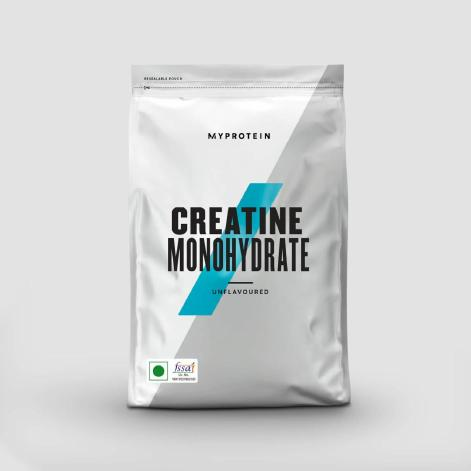
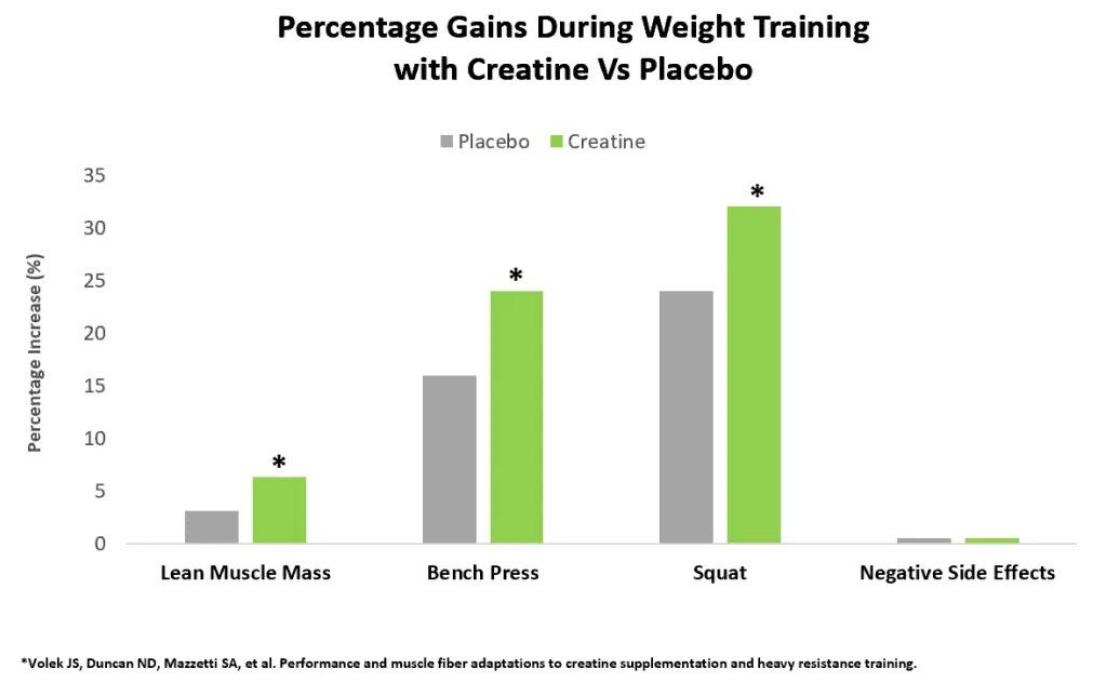

In [36]:
from IPython import display

images_html = ""
for i in range(len(base64_images_to_user_query)):
  images_html += f'<img src="data:image/png;base64,{base64_images_to_user_query[i]}" />'

print("Query: " + user_query)
print("Answer: " + response_to_user.text)
display.HTML(images_html)

# Phase 5

- Clear all file system

In [ ]:
!rm -rf pdfs
!rm -rf images

# The END 😀